# Parameter Space Exploration

In this notebook, we'll demonstrate the use of pysd for exploring the impact of parameter choices on on model outcome. The fine grained control that python and pysd gives over model execution, along with methods for aggregating and analzing simulation results, show what may be gained by bringing the model out of the standard SD environment into python's more explicit programming framework.

We'll use a standard Susceptible-Infectious-Recovered compartmental model, which is driven by two primary parameters: the contact-infectivity, representing both the frequency of contacts between individuals in a population and the likelihood that a disease will be transmitted by any given contact; and the average duration of infectivity.

![SIR stock and flow](SIR_Stock_and_Flow.png)


In [13]:
%pylab inline
import pysd
import pandas as pd
import numpy as np
import matplotlib.cm as cm

Populating the interactive namespace from numpy and matplotlib



###Import the model
We'll begin by importing the model, running it with the default parameters, and plotting the stock values over the timeseries in the model.

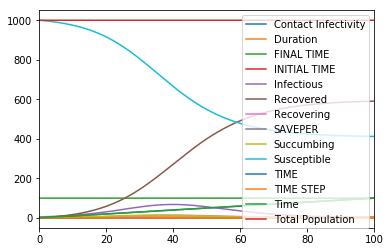

In [14]:
model = pysd.read_vensim('SIR.mdl')
model.run().plot();

The names of the relevant parameters have been subtly changed by pysd to make them python compatible:

In [8]:
model

###Define a range of parameters to investigate

We'll look at a range of reasonable parameter values for the contact infectivity and duration, sweeping a full order of magnitude. We can trade run-time with parameter resolution.

After defining the range of parameters, we'll map them to a 2 dimensional grid to facilitate computation and display.

In [15]:
contact_infectivities = np.arange(0,1,.25)
durations = np.arange(.5,10,.5)

ci_grid, d_grid = np.meshgrid(contact_infectivities, durations) 

###How does the final spread of the disease vary with the input parameters?

There are a variety of ways to iterate the model. In this notebook, we'll use numpy's vectorize capability, as it efficiently maps to the multidimensional grids that we're looking at. We use an inline function declaration which takes our two parameters of interest as inputs, runs the model, and selects the last value that the simulation reports for the 'susceptible' stock. 

Numpy's vectorize utility gives us the ability to take this function, which is defined for single-valued inputs, and pass in array inputs. The output of the vectorized function will be an array with the same shape as the inputs, representing the output of the function with inputs corresponding to the values of the input arrays.

In [16]:
endstate = np.vectorize(lambda ci, d: model.run(
    params={'contact_infectivity':ci, 'duration':d})['Susceptible'].iloc[-1])
unaffected_grid = endstate(ci_grid, d_grid)
model.run(params={'contact_infectivity':0.3, 'duration':10})

KeyboardInterrupt: 

In an SIR model, if the rate of recovery exceeds the rate of infection, then a disease will fail to spread through the population. As our two parameters each control one of these flows, we know that there is some tradeoff between the two in controlling the spread of the disease.

If we plot the number of people who are still susceptible to the disease at the end of the simulation vs the two parameters, we can get a sense for this tradeoff. 

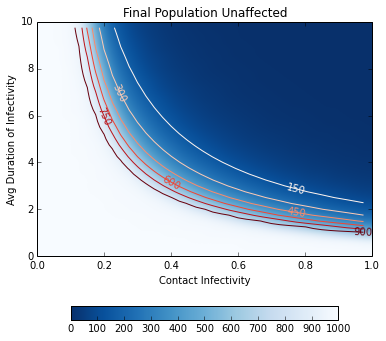

In [6]:
plt.figure(figsize=(6,6))

#plot a heatmap from
im = plt.imshow(unaffected_grid, interpolation='bicubic', cmap=cm.Blues_r, origin='lower', extent=(0,1,0,10))
plt.colorbar(im, orientation='horizontal', shrink=0.8)

#add contours to give detail to the gradation
CS = plt.contour(ci_grid, d_grid, unaffected_grid, cmap=cm.Reds, extent=(0,1,0,10))
plt.clabel(CS, inline=0, fontsize=10, fmt='%i');

plt.axis('auto')
plt.xlabel('Contact Infectivity')
plt.ylabel('Avg Duration of Infectivity')
plt.title('Final Population Unaffected');

### How does the timing of the peak infectivity very with the input parameters?

Instead of looking at the level of infection itself, we can ask how the time at which the largest number of people are infected changes as we vary the input parameters. This will give us a sense for regions of the parameter space in which the disease is propagating 'fast' or 'slow'.

As before, we vectorize an inline function written to find the time of the peak, and broadcast it over our parameter space. This is a bit inefficient, as we are running all of the cases again, just to take a single value from each run; but I'm willing to bear that for the sake of demonstrating the method.

In [7]:
tmax = np.vectorize(lambda ci, d: model.run(params={'contact_infectivity':ci, 'duration':d})['infectious'].idxmax())
tmax_grid = tmax(ci_grid, d_grid)

When we plot this behavior, there are some unexpected discontinuities in the output pattern, which arise because we sampled our parameter space at even intervals, and then interpolated values between them. In the future, it would be interesting to use an adaptive sampler to get better resolution in the region of the sample space showing more interesting behavior.

Looking at the trends themselves, we see that the slowest propagation of the disease occurs for long durations of infectivity, just at the border where the propagation rate is sufficient for initial growth of the infectious population. Given a specific contact infectivity, for cases where the disease successfully propagates, the timing of the maximum number of infections is largely insensitive to the duration of the infectivity.

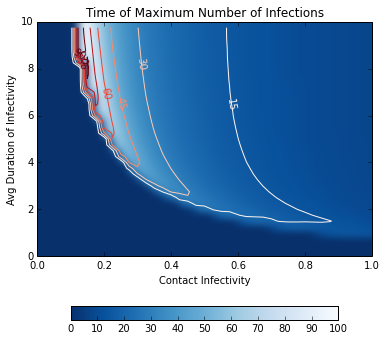

In [8]:
plt.figure(figsize=(6,6))
im = plt.imshow(tmax_grid, interpolation='bicubic', cmap=cm.Blues_r, origin='lower', extent=(0,1,0,10))
plt.colorbar(im, orientation='horizontal', shrink=0.8)


CS = plt.contour(ci_grid, d_grid, tmax_grid, cmap=cm.Reds, extent=(0,1,0,10), antialiased=True)
plt.clabel(CS, inline=0, fontsize=10, fmt='%i');


plt.axis('auto')
plt.xlabel('Contact Infectivity')
plt.ylabel('Avg Duration of Infectivity')
plt.title('Time of Maximum Number of Infections');

### Putting the two together

If we plot the timing of the peak infectivity with contour lines representing the final infected population, we can see a bit more of what is going on. The peak infectivity is naturally at $t_0$ for the region of the parameter space in which the disease fails to propagate. 

Exceptionally slow cases span a large range of final infection counts, as the contour lines are fairly close together in this region. This implies that we should spot-check runs in this region to find out if the peak time is driven more by the simulation failing to reach a natural maximum before the end of the simulation run at  $t_{100}$.

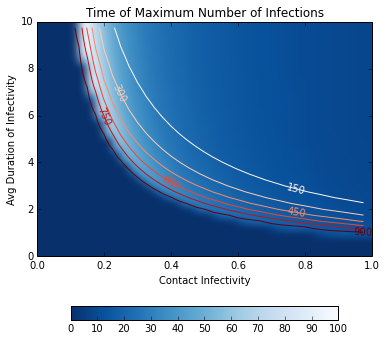

In [9]:
plt.figure(figsize=(6,6))
im = plt.imshow(tmax_grid, interpolation='bicubic', cmap=cm.Blues_r, origin='lower', extent=(0,1,0,10))
plt.colorbar(im, orientation='horizontal', shrink=0.8)


CS = plt.contour(ci_grid, d_grid, unaffected_grid, cmap=cm.Reds, extent=(0,1,0,10), antialiased=True)
plt.clabel(CS, inline=0, fontsize=10, fmt='%i');


plt.axis('auto')
plt.xlabel('Contact Infectivity')
plt.ylabel('Avg Duration of Infectivity')
plt.title('Time of Maximum Number of Infections');